# This notebook caculates, validates and visualizes the hydraulic capacity of culverts
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from shapely.geometry import box
from matplotlib import rcParams
import warnings
warnings.filterwarnings("ignore")
import folium
from folium import plugins
from branca.element import Template, MacroElement
from branca.element import Element
from scipy.optimize import fsolve
from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression
from datetime import datetime

In [2]:
# plot font parameter
plt.rcParams['font.family'] = 'Arial'

# Polynomial Generation (HY8 approach)

Inlet control means that flow within the culvert barrel is supercritical and not capable of transmitting losses upstream. The determination of the headwater depth, therefore, is not found using the energy equation, but is the result of many scaled model tests. In HDS-5 (Appendix A), submerged and unsubmerged equations developed by the National Bureau of Standards from the scaled model tests were originally used to determine headwater depths. These equations required four coefficients, K, M, c, and Y. Unfortunately, once plotted, the transition zone between unsubmerged and submerged flow was not well defined. For the purposes of the HY-8 program, a fifth-degree polynomial curve was fitted through the three regions of flow: unsubmerged, transition, and submerged (see equation below). Fifth-degree polynomial coefficients were obtained for all combinations of culvert shape and inlet configurations.
$$
\frac{HW}{D} = a + b \left[ \frac{Q}{BD^{1.5}} \right] + c \left[ \frac{Q}{BD^{1.5}} \right]^2 + d \left[ \frac{Q}{BD^{1.5}} \right]^3 + e \left[ \frac{Q}{BD^{1.5}} \right]^4 + f \left[ \frac{Q}{BD^{1.5}} \right]^5
$$

In [3]:
# Load the shapefile of the culverts and extract each variable needed for hydraulic capacity calculation
file_path = r"D:\culvert repo\Results\Rise\culvert dataframe  with height.xlsx"
culvert1 = pd.read_excel(file_path)
# Remove the duplicated second rows based on the 'BIN' column
culvert = culvert1.drop_duplicates(subset=['BIN'],keep='first')

In [4]:
# Load the shapefile of the culverts and extract each variable needed for hydraulic capacity calculation
#file_path = r"D:\culvert repo\data\rise\culvert dataframe  with height.xlsx"
#culvert1 = pd.read_excel(file_path)
# Remove the duplicated second rows based on the 'BIN' column
#culvert1 = culvert1.drop_duplicates(subset=['BIN'],keep='first')
# Display the first 5 rows of culverts dimentions
#culvert1[['MAXIMUM SPAN LENGTH (FT)','Height']].head()

In [5]:
# Load watershed-related attributes of the culverts
#file_path = r"D:\culvert repo\Results\waterhsed_delineation_dir\cleaned_watersheds_info.xlsx"
#culvert2 = pd.read_excel(file_path)
# Remove the duplicated second rows based on the 'BIN' column
#culvert2 = culvert2.drop_duplicates(subset=['BIN'],keep='first')
# Display the first few rows of the DataFrame
#culvert2.head()

In [ ]:
# Merge watershed-related attributes with culvert data frame
#culvert = culvert1.merge(culvert2, on='BIN', how='inner')
# Display the first 5 rows of the resulting GeoDataFrame
culvert.head()

In [5]:
np.shape (culvert)

(8062, 40)

In [6]:
# print features of the merged dataframe
print(", ".join(culvert.columns))

Unnamed: 0, BIN, REGION, COUNTY, GTMS - MATERIAL, GTMS - TYPE, CARRIED, CROSSED, LATITUDE (DEGREES), LATITUDE (MINUTES), LONGITUDE (DEGREES), LONGITUDE (MINUTES), YEAR BUILT, NUMBER OF SPANS, NUMBER OF MAIN SPANS, MAXIMUM SPAN LENGTH (FT), BRIDGE LENGTH (FT), OUT TO OUT WIDTH (FT), DECK AREA (SQ FT), BA WINGWALL TYPE, EA WINGWALL TYPE, BA SKEW ANGLE, EA SKEW ANGLE, DEPTH OF COVER, BARREL LENGTH, FUNCTIONAL CLASSIFICATION, DETOUR LENGTH (MI), STREAM BED MATERIAL, BANK PROTECTION, VELOCITY OF CURRENT (FPS), FEATURES AFFECTING FLOW, GENERAL RECOMMENDATION, SCOUR CRITICAL CODE, MATERIAL, DESIGN TYPE, ORIGINAL CONTRACT NUMBER, LATITUDE, LONGITUDE, Height, meth_extrac


#  Visualization

## year built

In [7]:
# "YEAR BUILT" feature shows geometric features of the culverts 
# unique values of 'YEAR BUILT'
unique_YEAR_BUILT = culvert['YEAR BUILT'].unique()
# Print unique values
print(unique_YEAR_BUILT)

[1928 1929 1952 1988 1958 1960 1967 1930 1922 1938 1959 2014 1966 1969
 1989 1933 1986 1957 2002 2001 2006 1927 1965 1931 1911 1920 1951 1962
 1932 1942 1935 1948 1954 1999 1949 1964 1990 1985 2003 1926 1963 1974
 1901 2009 2018 2005 2004 1993 1997 1975 1979 1912 1970 1977 2012 2020
 1998 1923 2007 2011 2019 1984 2013 1992 1991 1995 1980 1850 1946 2000
 1910 1955 1937 2008 1950 1914 1978 1968 1900 1994 1700 1944 1947 2015
 1996 1983 1941 2099 1953 1945 1936 1956 2010 2017 1976 1971 2016 1940
 2022 1934 1924 2021 1981 1939 1972 1987 1925 1961 1919 1913 1973 1921
 1890 1904 1916 1918 1909 1908 1915 1903 1907 1982 1906 1943 1880 1917
 1905 1902 1875 1883 1823 1898 2023 1885 1881]


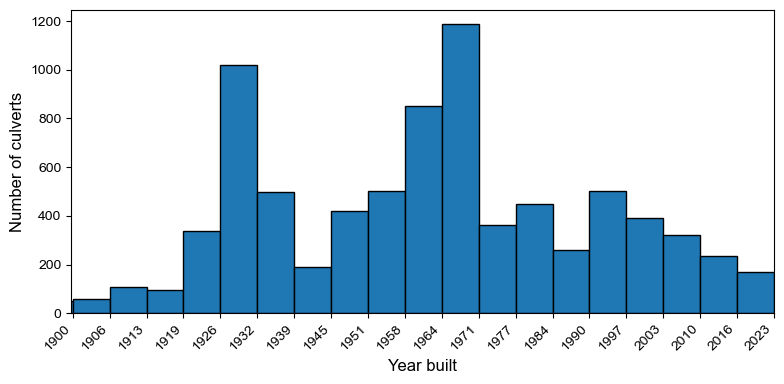

In [8]:
# Drop missing values and filter out year 2099
year_built_clean = culvert['YEAR BUILT'].dropna()
year_built_clean = year_built_clean[year_built_clean != 2099]

# Set font styles
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# Compute histogram manually to access bin edges
counts, bin_edges = np.histogram(year_built_clean, bins=50)

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(year_built_clean, bins=bin_edges, edgecolor='black')

# Set x-axis ticks at bin edges (start and end of each bin)
plt.xticks(bin_edges, labels=[f"{int(edge)}" for edge in bin_edges], rotation=45, ha='right')

# Add labels and layout
plt.xlabel('Year built')
plt.ylabel('Number of culverts')
plt.xlim(1900,2023)
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culverts_year_built_hist.png', dpi=300)
plt.show()


## DESIGN TYPE

In [9]:
# "DESIGN TYPE" feature shows geometric features of the culverts 
# unique values of 'DESIGN TYPE'
unique_design_types = culvert['DESIGN TYPE'].unique()
# Print  unique values
print(unique_design_types)

[40. 41. 27. 43. 42. 26. 25.  1. nan  9. 38. 12. 22.  8. 13.  3.  5.  2.]


In [10]:
# Remove the records with nan design type 
culvert = culvert.dropna(subset=['DESIGN TYPE'])

### Meaning of the "DESIGN TYPE" Codes

- **40**: Single Box Culvert 
- **41**: Multiple Pipe Culvert (FHWA)  
- **27**: Frame
- **43**: Multiple Box Culvert  
- **42**: Single/Multiple Pipe Culvert (FHWA/NYS)  
- **26**: Metal Pipe Arch (Pipe)  
- **25**: Deck Arch - Closed Spandrel  
- **01**: Slab  
- **09**: Rolled Beam, Multi-Girder  
- **38**: Single Box  
- **12**: Rolled Beam - Jack Arch  
- **22**: Thru Arch  
- **08**: Segmental Box  
- **13**: Plate Girder - Multi-Girder  
- **03**: Box, Adjacent  
- **05**: Tee Beam or NEXT Beam  
- **02**: Slab, Voided  

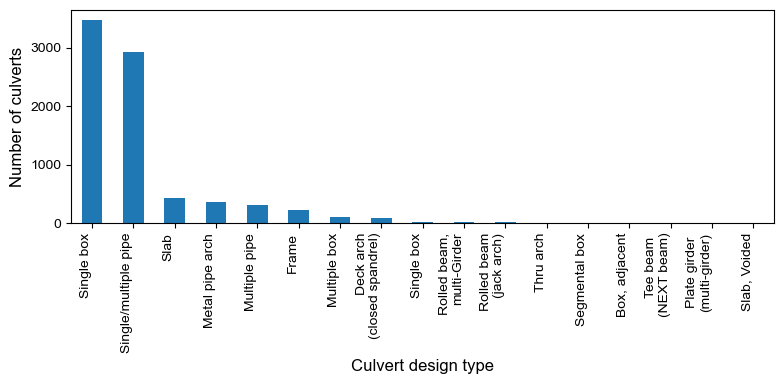

In [11]:
# Labeling map
design_type_map = {
    40: 'Single box',
    41: 'Multiple pipe',
    27: 'Frame',
    43: 'Multiple box',
    42: 'Single/multiple pipe',
    26: 'Metal pipe arch',
    25: 'Deck arch\n(closed spandrel)',
    1: 'Slab',
    9: 'Rolled beam,\nmulti-Girder',
    38: 'Single box',
    12: 'Rolled beam\n(jack arch)',
    22: 'Thru arch',
    8: 'Segmental box',
    13: 'Plate girder \n(multi-girder)',
    3: 'Box, adjacent',
    5: 'Tee beam \n(NEXT beam)',
    2: 'Slab, Voided'
}

# Count the number of culverts for each design type
design_type_counts = culvert['DESIGN TYPE'].value_counts()

# Map the design type numbers to their descriptions
design_type_counts.index = design_type_counts.index.map(design_type_map)

# Plot the results
# Set global font properties
plt.rcParams.update({
    'font.size': 12,  # Default font size
    'axes.titlesize': 12,  # Title font size
    'axes.labelsize': 12,  # X and Y labels font size
    'xtick.labelsize': 10,  # X tick labels font size
    'ytick.labelsize': 10,  # Y tick labels font size
})

# Plot the results
plt.figure(figsize=(8, 4))
design_type_counts.plot(kind='bar')

# Title and labels will automatically use the global font settings
#plt.title('Number of Culverts by Design Type')
plt.xlabel('Culvert design type')
plt.ylabel('Number of culverts')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culverts_design_type.png', dpi=300)
plt.show()

## Material

In [12]:
# Get all unique values from the 'DESIGN TYPE' column
unique_span_material = culvert['GTMS - MATERIAL'].unique()
# Print all unique values
print(unique_span_material)

[1 3 0 8 9 2 5 4]


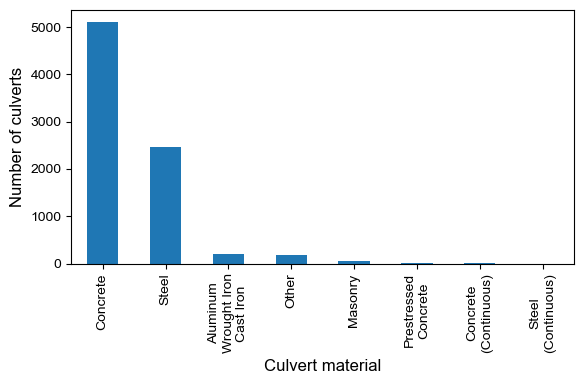

In [13]:
# Mapping of GTMS material codes to their descriptions
material_map = {
    1: 'Concrete',
    2: 'Concrete\n(Continuous)',
    3: 'Steel',
    4: 'Steel\n(Continuous)',
    5: 'Prestressed\nConcrete',
    6: 'Prestressed \nConcrete\n(Continuous)',
    7: 'Timber',
    8: 'Masonry',
    9: 'Aluminum\nWrought Iron\nCast Iron',
    0: 'Other',
    'A': 'Unpainted Steel',
    'B': 'Unpainted Steel\n(Continuous)'
}

material_counts = culvert['GTMS - MATERIAL'].value_counts()

# Map the material codes to their descriptions
material_counts.index = material_counts.index.map(material_map)

# Plot the results
plt.figure(figsize=(6, 4))
material_counts.plot(kind='bar')
#plt.title('Number of Culverts by Material Type', fontsize=16)
plt.xlabel('Culvert material')
plt.ylabel('Number of culverts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\culverts_material_type.png', dpi=300)
plt.show()

In [14]:
# Remove the rows with nan height 
culvert = culvert.dropna(subset=['Height'])
culvert['rise_expected']=pd.to_numeric(culvert['Height'], errors='coerce')

In [15]:
# Function to calculate allowable max_HW_D
def calculate_max_HW_D_hight(row):
    rise = row['rise_expected']
    if rise>= 5:
        if rise==5:
            return 1.2
        else:
            return 1
    if rise <5:
        if rise <=4:
            return 1.5
        else:
            return 1.2
# apply the function
culvert ['max_HW_D'] = culvert.apply(calculate_max_HW_D_hight, axis=1)

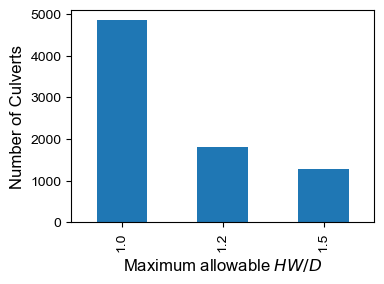

In [16]:
# Count occurrences of unique values in max_HW_D
max_hw_counts = culvert['max_HW_D'].value_counts()
# Plot the results
plt.figure(figsize=(4, 3))
max_hw_counts.plot(kind='bar')

# Add labels and formatting
plt.xlabel(f'Maximum allowable $HW/D$', fontsize=12)
plt.ylabel('Number of Culverts', fontsize=12)
plt.xticks(rotation=90, fontsize=10)

#plt.title('Distribution of Max HW/D in Culverts', fontsize=14)
plt.tight_layout()
# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\culverts_max_HW_D.png', dpi=300)
plt.show()

In [17]:
num_nans = culvert['DEPTH OF COVER'].isna().sum()
print(f"Number of NaNs in 'DEPTH OF COVER': {num_nans}")

Number of NaNs in 'DEPTH OF COVER': 41


In [18]:
# HW calculation
culvert['HW']=culvert['DEPTH OF COVER']+culvert['rise_expected'] 
culvert['HW/D']=culvert['HW']/culvert['rise_expected']

In [19]:
def update_HW(row):
    HW_D = row['HW/D'] 
    max_HW_D=row['max_HW_D']
    if HW_D> max_HW_D:
        row['HW/D']=max_HW_D
    return row

# Apply the function 
culvert = culvert.apply(update_HW, axis=1)

In [22]:
culvert.columns

Index(['Unnamed: 0', 'BIN', 'REGION', 'COUNTY', 'GTMS - MATERIAL',
       'GTMS - TYPE', 'CARRIED', 'CROSSED', 'LATITUDE (DEGREES)',
       'LATITUDE (MINUTES)', 'LONGITUDE (DEGREES)', 'LONGITUDE (MINUTES)',
       'YEAR BUILT', 'NUMBER OF SPANS', 'NUMBER OF MAIN SPANS',
       'MAXIMUM SPAN LENGTH (FT)', 'BRIDGE LENGTH (FT)',
       'OUT TO OUT WIDTH (FT)', 'DECK AREA (SQ FT)', 'BA WINGWALL TYPE',
       'EA WINGWALL TYPE', 'BA SKEW ANGLE', 'EA SKEW ANGLE', 'DEPTH OF COVER',
       'BARREL LENGTH', 'FUNCTIONAL CLASSIFICATION', 'DETOUR LENGTH (MI)',
       'STREAM BED MATERIAL', 'BANK PROTECTION', 'VELOCITY OF CURRENT (FPS)',
       'FEATURES AFFECTING FLOW', 'GENERAL RECOMMENDATION',
       'SCOUR CRITICAL CODE', 'MATERIAL', 'DESIGN TYPE',
       'ORIGINAL CONTRACT NUMBER', 'LATITUDE', 'LONGITUDE', 'Height',
       'meth_extrac', 'rise_expected', 'max_HW_D', 'HW', 'HW/D'],
      dtype='object')

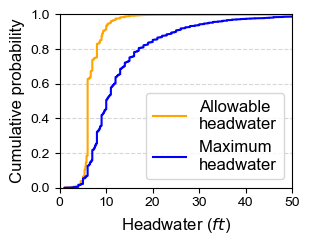

In [20]:
# Drop rows with NaN in required columns
df = culvert[['HW/D', 'rise_expected', 'HW']].dropna()

# Calculate derived headwater from HW/D * rise
culvert_data = df['HW/D'] * df['rise_expected']
hw_data = df['HW']

# Sort and compute CDFs
sorted_culvert_data = np.sort(culvert_data)
cdf_culvert_data = np.arange(1, len(sorted_culvert_data) + 1) / len(sorted_culvert_data)

sorted_hw_data = np.sort(hw_data)
cdf_hw_data = np.arange(1, len(sorted_hw_data) + 1) / len(sorted_hw_data)

# Plot
ratio = 0.75
plt.figure(figsize=(4*ratio, 3*ratio))
plt.plot(sorted_culvert_data, cdf_culvert_data, color='orange', linestyle='-', label="Allowable\nheadwater")
plt.plot(sorted_hw_data, cdf_hw_data, color='blue', linestyle='-', label="Maximum \nheadwater")
plt.xlabel("Headwater ($ft$)")
plt.ylabel("Cumulative probability")
plt.ylim(0,1)
plt.xlim(0, 50)
plt.grid(axis='y', which='major', linestyle="--", alpha=0.5)
plt.legend()
plt.savefig(r'D:\culvert repo\Results\Figures\num_culvert_HW.png', dpi=300, bbox_inches='tight')
plt.show()

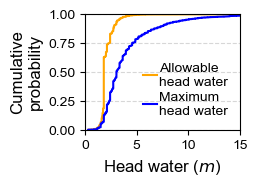

In [30]:
# Drop rows with NaN in required columns
df = culvert[['HW/D', 'rise_expected', 'HW']].dropna()

# Calculate derived headwater from HW/D * rise
culvert_data = df['HW/D'] * df['rise_expected']*0.3048
hw_data = df['HW']*0.3048

# Sort and compute CDFs
sorted_culvert_data = np.sort(culvert_data)
cdf_culvert_data = np.arange(1, len(sorted_culvert_data) + 1) / len(sorted_culvert_data)

sorted_hw_data = np.sort(hw_data)
cdf_hw_data = np.arange(1, len(sorted_hw_data) + 1) / len(sorted_hw_data)

# Plot
ratio = 0.5
plt.figure(figsize=(4*ratio, 3*ratio))
plt.plot(sorted_culvert_data, cdf_culvert_data, color='orange', linestyle='-', label="Allowable\nhead water")
plt.plot(sorted_hw_data, cdf_hw_data, color='blue', linestyle='-', label="Maximum \nhead water")
plt.xlabel("Head water ($m$)")   # << changed from ft to m
plt.ylabel("Cumulative\nprobability")
plt.ylim(0,1)
plt.xlim(0, 15)  # << adjust for metric scale (was 50 ft ≈ 15 m)
plt.grid(axis='y', which='major', linestyle="--", alpha=0.5)
plt.legend(fontsize=10, loc='lower right', handlelength=1,
    columnspacing=2.5, handletextpad=0.1, frameon=False, ncol=1, labelspacing=0.2)
plt.savefig(r'D:\culvert repo\Results\Figures\num_culvert_HW_paper.png', dpi=300, bbox_inches='tight')


# HY8 approach 


In [24]:
%%time
# Define the function to solve for Q
def equation(Q, a, b, c, d, e, f, HW_D, B, D):
    X = Q / (B * D**1.5)
    return a + b*X + c*X**2 + d*X**3 + e*X**4 + f*X**5 - HW_D

# Define coefficients for different DESIGN TYPE categories
coefficients_dict = {
    "general": [
        (0.122117, 0.505435, -0.10856, 0.0207809, -0.00136757, 0.00003456),
        (0.1067588, 0.4551575, -0.08128951, 0.01215577, -0.00067794, 0.0000148),
        (0.1666086, 0.3989353, -0.06403921, 0.01120135, -0.0006449, 0.000014566),
        (0.0724927, 0.507087, -0.117474, 0.0221702, -0.00148958, 0.000038),
        (0.144133, 0.461363, -0.0921507, 0.0200028, -0.00136449, 0.0000358),
        (0.0995633, 0.4412465, -0.07434981, 0.01273183, -0.0007588, 0.00001774)
    ],
    "41_42": [
        (0.187321, 0.56771, -0.156544, 0.0447052, -0.00343602, 8.96610E-05),
        (0.107137, 0.757789, -0.361462, 0.1233932, -0.01606422, 0.00076739),
        (0.167433, 0.538595, -0.149374, 0.0391543, -0.00343974, 0.000115882),
        (0.108786, 0.662381, -0.233801, 0.0579585, -0.0055789, 0.000205052),
        (0.114099, 0.653562, -0.233615, 0.0597723, -0.00616338, 0.000242832),
        (0.063343, 0.766512, -0.316097, 0.0876701, -0.009836951, 0.00041676),
        (0.08173, 0.698353, -0.253683, 0.065125, -0.0071975, 0.000312451),
        (0.167287, 0.558766, -0.159813, 0.0420069, -0.00369252, 0.000125169),
        (0.087483, 0.706578, -0.253295, 0.0667001, -0.006616151, 0.000250619),
        (0.120659, 0.630768, -0.218423, 0.0591815, -0.00599169, 0.000229287)
    ],
    "25_26": [
        (0.08905, 0.71255, -0.27092, 0.07925, -0.00798, 0.00029),
        (0.12263, 0.4825, -0.00002, -0.04287, 0.01454, -0.00117),
        (0.14168, 0.49323, -0.03235, -0.02098, 0.00989, -0.00086),
        (0.09219, 0.65732, -0.19423, 0.04476, -0.00176, -0.00012),
        (0.0833, 0.79514, -0.43408, 0.16377, -0.02491, 0.00141),
        (0.1062, 0.7037, -0.3531, 0.1374, -0.02076, 0.00117),
        (0.23645, 0.37198, -0.0401, 0.03058, -0.00576, 0.00045),
        (0.10212, 0.72503, -0.34558, 0.12454, -0.01676, 0.00081),
        (0.11128, 0.61058, -0.19494, 0.05129, -0.00481, 0.00017),
        (0.12346, 0.50432, -0.13261, 0.0402, -0.00448, 0.00021),
        (0.09728, 0.57515, -0.15977, 0.04223, -0.00374, 0.00012),
        (0.09455, 0.61669, -0.22431, 0.07407, -0.01002, 0.00054),
        (0.16884, 0.38783, -0.03679, 0.01173, -0.00066, 0.00002),
        (0.1301, 0.43477, -0.07911, 0.01764, -0.0011, 0.00002),
        (0.09618, 0.52593, -0.13504, 0.03394, -0.00325, 0.00013)
    ]
}

# Function to get coefficients based on DESIGN TYPE
def get_coefficients(design_type):
    if design_type in [41, 42]:
        return coefficients_dict["41_42"]
    elif design_type in [25, 26]:
        return coefficients_dict["25_26"]
    else:
        return coefficients_dict["general"]

# Iterate over each row in culvert
Q_results = []
Q_results_maxhw = []
coefficients_used = []

for _, row in culvert.iterrows():
    design_type = row['DESIGN TYPE']
    B = row['MAXIMUM SPAN LENGTH (FT)']
    D = row['rise_expected']
    HW_D = row['HW/D']
    max_HW_D= (row['DEPTH OF COVER'] + D) / D
    # Get correct coefficients
    coefficients = get_coefficients(design_type)
    coefficients_used.append(coefficients)
    # Initial guess for Q
    Q_initial_guess = 100

    # Solve for Q using HW_D
    Q_solutions = [fsolve(equation, Q_initial_guess, args=(a, b, c, d, e, f, HW_D, B, D))[0] for a, b, c, d, e, f in coefficients]
    Q_results.append(Q_solutions)
    
    # Solve for Q using max_HW_D
    Q_solutions_maxhw = [fsolve(equation, Q_initial_guess, args=(a, b, c, d, e, f, max_HW_D, B, D))[0] for a, b, c, d, e, f in coefficients]
    Q_results_maxhw.append(Q_solutions_maxhw)

# Add results to the dataframe
culvert['coefficients'] = coefficients_used
culvert['possible_Qs'] = Q_results
culvert['average_Q'] = culvert['possible_Qs'].apply(np.mean)
culvert['possible_Qs_maxhw'] = Q_results_maxhw
culvert['average_Q_maxhw'] = culvert['possible_Qs_maxhw'].apply(np.mean)

KeyboardInterrupt: 

In [ ]:
culvert['MAXIMUM SPAN LENGTH (FT)'][0]

np.float64(6.0)

### Save to excel file

In [ ]:
#coefficients
# Function to expand coefficient tuples into flat list of values
def expand_coefficients(row):
    flat = [item for group in row for item in group]
    return pd.Series(flat)
# Apply function and assign column names
expanded = culvert['coefficients'].apply(expand_coefficients)
# Rename columns to a_1, b_1, ..., f_6
coefficient_labels = ['a', 'b', 'c', 'd', 'e', 'f']
num_groups = int(expanded.shape[1] / len(coefficient_labels))
expanded.columns = [f"{letter}_{i+1}" for i in range(num_groups) for letter in coefficient_labels]
# Concatenate with the original DataFrame
culvert = pd.concat([culvert, expanded], axis=1)
# Show all columns when printing DataFrames
pd.set_option('display.max_columns', None)


In [ ]:
# Function to expand Q values into flat columns
def expand_Qs(row):
    return pd.Series(row)

# Apply function and assign column names
expanded_Qs = culvert['possible_Qs'].apply(expand_Qs)

# Rename columns as Q_1, Q_2, ..., Q_6
expanded_Qs.columns = [f"Q_{i+1}" for i in range(expanded_Qs.shape[1])]

# Concatenate with the original DataFrame (without dropping 'possible_Qs')
culvert = pd.concat([culvert, expanded_Qs], axis=1)

In [ ]:
# Function to expand max Q values into flat columns
def expand_max_Qs(row):
    return pd.Series(row)

# Apply function and assign column names
expanded_max_Qs = culvert['possible_Qs_maxhw'].apply(expand_max_Qs)

# Rename columns as max_Q_1, max_Q_2, ..., max_Q_6
expanded_max_Qs.columns = [f"max_Q_{i+1}" for i in range(expanded_max_Qs.shape[1])]

# Concatenate with the original DataFrame (keep 'possible_Qs_maxhw')
culvert = pd.concat([culvert, expanded_max_Qs], axis=1)


In [ ]:

#culvert = culvert.drop(['possible_Qs', 'possible_Qs_maxhw'], axis=1)
outculvert=culvert.rename(columns={'possible_Qs': 'All possible hydraulic discharges (allowable head water) (ft^3/s)',
                                   'average_Q': 'Average hydraulic discharges (allowable head water) (ft^3/s)',
                                   'possible_Qs_maxhw': 'All possible hydraulic discharges (maximum head water) (ft^3/s)',
                                   'average_Q_maxhw': 'Average hydraulic discharges (maximum head water) (ft^3/s)',
                                   'meth_extrac':'Method of rise extraction'
                                    }, inplace=False)  



outculvert.to_excel('D:\culvert repo\Results\Excel\Hydraulic capacity\hydraulic_capacity.xlsx', index=False) #save

In [ ]:
culvert['Q'] = culvert['average_Q']# just to make the column name easier
culvert['Q_max'] = culvert['average_Q_maxhw']# just to make the column name easier

### Validation by comparing resutls with comprehensive hydraulic simulation of HY8

In [25]:
data = {
    "BIN": ["C640680", "C640690", "C640700", "C640710", "C640720", "C640730", "C640740",
            "C641060", "C641070", "C641080", "C641110", "C641130", "C641530","C641550",
            "C641570", 'C641610',"C641620", "C641660", "C641690", "CA00395"],
    "NYSDOT Rise": [8.53, 10, 3.91, 3.91, 5.58, 5.42, 5.42, 5, 6.91, 7.91, 8, 6, 3.7, 5, 7, 5, 5, 8, 8, 5],
    "Rise (Inspection Report)": [9.1, 14, 4, 4, 6, 5.8, 5.75, 5, 7, 7.7, 8, 6, 3.7, 5, 7, 5, 5, 8, 8, 6]
}

df = pd.DataFrame(data)
df.head()

,BIN,NYSDOT Rise,Rise (Inspection Report)
0,C640680,8.53,9.1
1,C640690,10.00,14.0
2,C640700,3.91,4.0
3,C640710,3.91,4.0
4,C640720,5.58,6.0


In [26]:
# Merge culvert dataset with NYSDOT Rise data based on BIN
culvert = culvert.merge(df, on="BIN", how="left")

In [27]:
# Update expected_rise with NYSDOT Rise where available
culvert["rise_expected"] = culvert["NYSDOT Rise"].combine_first(culvert["rise_expected"])

In [28]:
# List of BIN numbers and their corresponding hydraulic capacities
bin_hydraulic_capacity = {
    "C641530": 149.55, "C641550": 176.56, "C641570": 638.24,
    "C641610": 195.51, "C641620": 384.52, "C641660": 1072.94,
    "C641690": 1071.28, "C640680": 1437.9, "C640690": 2253.15,
    "C640700": 191.92, "C640710": 191.88, "C640720": 296.83,
    "C640730": 239.33, "C640740": 286.28, "CA00395": 186.48,
    "C641060": 487.46, "C641070": 452.25, "C641080": 645.32,
    "C641110": 1339.93, "C641130": 1101.01
}

# Filter the dataset for the specified BIN numbers
specific_rows = culvert[culvert['BIN'].isin(bin_hydraulic_capacity.keys())]

# Add hydraulic capacities to the filtered rows
specific_rows['Hydraulic Capacity (cfs)'] = specific_rows['BIN'].map(bin_hydraulic_capacity)

# Display the updated rows
#print(specific_rows[['BIN', 'Hydraulic Capacity (cfs)', 'rise_expected', 
#                     'MAXIMUM SPAN LENGTH (FT)', 'DESIGN TYPE', 'BARREL LENGTH','DEPTH OF COVER','HW/D',
#                     'GTMS - MATERIAL','max_HW_D','HW/D', 
#                     'Q','Hydraulic Capacity (cfs)']])

In [29]:
%%time
# Define the function to solve for Q
def equation(Q, a, b, c, d, e, f, HW_D, B, D):
    X = Q / (B * D**1.5)
    return a + b*X + c*X**2 + d*X**3 + e*X**4 + f*X**5 - HW_D

# Define coefficients for different DESIGN TYPE categories
coefficients_dict = {
    "general": [
        (0.122117, 0.505435, -0.10856, 0.0207809, -0.00136757, 0.00003456),
        (0.1067588, 0.4551575, -0.08128951, 0.01215577, -0.00067794, 0.0000148),
        (0.1666086, 0.3989353, -0.06403921, 0.01120135, -0.0006449, 0.000014566),
        (0.0724927, 0.507087, -0.117474, 0.0221702, -0.00148958, 0.000038),
        (0.144133, 0.461363, -0.0921507, 0.0200028, -0.00136449, 0.0000358),
        (0.0995633, 0.4412465, -0.07434981, 0.01273183, -0.0007588, 0.00001774)
    ],
    "41_42": [
        (0.187321, 0.56771, -0.156544, 0.0447052, -0.00343602, 8.96610E-05),
        (0.107137, 0.757789, -0.361462, 0.1233932, -0.01606422, 0.00076739),
        (0.167433, 0.538595, -0.149374, 0.0391543, -0.00343974, 0.000115882),
        (0.108786, 0.662381, -0.233801, 0.0579585, -0.0055789, 0.000205052),
        (0.114099, 0.653562, -0.233615, 0.0597723, -0.00616338, 0.000242832),
        (0.063343, 0.766512, -0.316097, 0.0876701, -0.009836951, 0.00041676),
        (0.08173, 0.698353, -0.253683, 0.065125, -0.0071975, 0.000312451),
        (0.167287, 0.558766, -0.159813, 0.0420069, -0.00369252, 0.000125169),
        (0.087483, 0.706578, -0.253295, 0.0667001, -0.006616151, 0.000250619),
        (0.120659, 0.630768, -0.218423, 0.0591815, -0.00599169, 0.000229287)
    ],
    "25_26": [
        (0.08905, 0.71255, -0.27092, 0.07925, -0.00798, 0.00029),
        (0.12263, 0.4825, -0.00002, -0.04287, 0.01454, -0.00117),
        (0.14168, 0.49323, -0.03235, -0.02098, 0.00989, -0.00086),
        (0.09219, 0.65732, -0.19423, 0.04476, -0.00176, -0.00012),
        (0.0833, 0.79514, -0.43408, 0.16377, -0.02491, 0.00141),
        (0.1062, 0.7037, -0.3531, 0.1374, -0.02076, 0.00117),
        (0.23645, 0.37198, -0.0401, 0.03058, -0.00576, 0.00045),
        (0.10212, 0.72503, -0.34558, 0.12454, -0.01676, 0.00081),
        (0.11128, 0.61058, -0.19494, 0.05129, -0.00481, 0.00017),
        (0.12346, 0.50432, -0.13261, 0.0402, -0.00448, 0.00021),
        (0.09728, 0.57515, -0.15977, 0.04223, -0.00374, 0.00012),
        (0.09455, 0.61669, -0.22431, 0.07407, -0.01002, 0.00054),
        (0.16884, 0.38783, -0.03679, 0.01173, -0.00066, 0.00002),
        (0.1301, 0.43477, -0.07911, 0.01764, -0.0011, 0.00002),
        (0.09618, 0.52593, -0.13504, 0.03394, -0.00325, 0.00013)
    ]
}

# Function to get coefficients based on DESIGN TYPE
def get_coefficients(design_type):
    if design_type in [41, 42]:
        return coefficients_dict["41_42"]
    elif design_type in [25, 26]:
        return coefficients_dict["25_26"]
    else:
        return coefficients_dict["general"]

# Iterate over each row in specific_rows
Q_results = []
Q_results_maxhw = []

for _, row in specific_rows.iterrows():
    design_type = row['DESIGN TYPE']
    B = row['MAXIMUM SPAN LENGTH (FT)']
    D = row['rise_expected']
    HW_D = (row['DEPTH OF COVER'] + D) / D
    max_HW_D = row['HW/D']
    
    # Get correct coefficients
    coefficients = get_coefficients(design_type)
    
    # Initial guess for Q
    Q_initial_guess = 100

    # Solve for Q using HW_D
    Q_solutions = [fsolve(equation, Q_initial_guess, args=(a, b, c, d, e, f, HW_D, B, D))[0] for a, b, c, d, e, f in coefficients]
    Q_results.append(Q_solutions)
    
    # Solve for Q using max_HW_D
    Q_solutions_maxhw = [fsolve(equation, Q_initial_guess, args=(a, b, c, d, e, f, max_HW_D, B, D))[0] for a, b, c, d, e, f in coefficients]
    Q_results_maxhw.append(Q_solutions_maxhw)

# Add results to the dataframe
specific_rows['possible_Qs'] = Q_results
specific_rows['average_Q'] = specific_rows['possible_Qs'].apply(np.mean)
specific_rows['Q'] = specific_rows['average_Q']

specific_rows['possible_Qs_maxhw'] = Q_results_maxhw
specific_rows['average_Q_maxhw'] = specific_rows['possible_Qs_maxhw'].apply(np.mean)

# Display the results
#print(specific_rows[['DESIGN TYPE', 'possible_Qs', 'average_Q', 'possible_Qs_maxhw', 'average_Q_maxhw']])

CPU times: total: 31.2 ms
Wall time: 21.8 ms


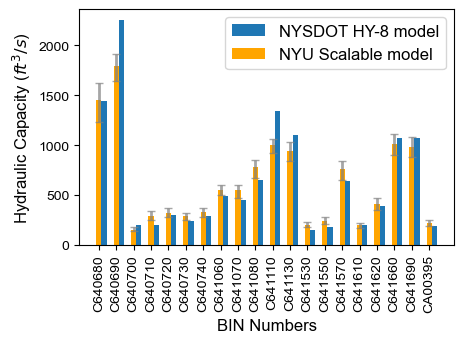

In [ ]:
# Ensure necessary columns exist and are numeric
filtered_data = specific_rows[['BIN', 'Q', 'Hydraulic Capacity (cfs)', 'possible_Qs', 'average_Q_maxhw', 'possible_Qs_maxhw']].dropna()

# Compute min and max for possible_Qs
filtered_data['Q_min'] = filtered_data['possible_Qs'].apply(min)
filtered_data['Q_max'] = filtered_data['possible_Qs'].apply(max)

# Compute min and max for possible_Qs_maxhw
filtered_data['Q_min_maxhw'] = filtered_data['possible_Qs_maxhw'].apply(min)
filtered_data['Q_max_maxhw'] = filtered_data['possible_Qs_maxhw'].apply(max)
ratio=1.2

# Plot the data
plt.figure(figsize=(4*ratio, 3*ratio))
x = np.arange(len(filtered_data))  # Create indices for each BIN

# Bar plot for Hydraulic Capacity
plt.bar(x + 0.3, filtered_data['Hydraulic Capacity (cfs)'], width=0.3, label=f'NYSDOT HY-8 model')

# Bar plot for Q
plt.bar(x, filtered_data['Q'], width=0.3, color='orange', label=f'NYU Scalable model')

# Bar plot for average_Q_maxhw
#plt.bar(x + 0.3, filtered_data['average_Q_maxhw'], width=0.3, label=f'Maximum allowable discharge ($ft^3/s$)', color='green')

# Add uncertainty band around Q
plt.errorbar(
    x, filtered_data['Q'], 
    yerr=[filtered_data['Q'] - filtered_data['Q_min'], filtered_data['Q_max'] - filtered_data['Q']], 
    fmt='none', ecolor='gray', elinewidth=2, capsize=3, alpha=0.7)

# Add uncertainty band around average_Q_maxhw
#plt.errorbar(
#    x + 0.3, filtered_data['average_Q_maxhw'], 
#    yerr=[filtered_data['average_Q_maxhw'] - filtered_data['Q_min_maxhw'], 
#          filtered_data['Q_max_maxhw'] - filtered_data['average_Q_maxhw']], 
#    fmt='none', ecolor='gray', elinewidth=2, capsize=3, alpha=0.7)

# Add BIN labels to the x-axis
plt.xticks(x, filtered_data['BIN'], rotation=90)

# Add labels and title
plt.xlabel('BIN Numbers', fontsize=12)
plt.ylabel('Hydraulic Capacity ($ft^3/s$)', fontsize=12)
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig(r'D:\culvert repo\Results\Figures\Q_vs_Hydraulic_Capacity_with_maxhw.png', dpi=300)
plt.show()

In [63]:
specific_rows.BIN

4635    C640680
4636    C640690
4637    C640700
4638    C640710
4639    C640720
4640    C640730
4641    C640740
4662    C641060
4663    C641070
4664    C641080
4666    C641110
4668    C641130
4704    C641530
4706    C641550
4708    C641570
4710    C641610
4711    C641620
4712    C641660
4713    C641690
7852    CA00395
Name: BIN, dtype: object

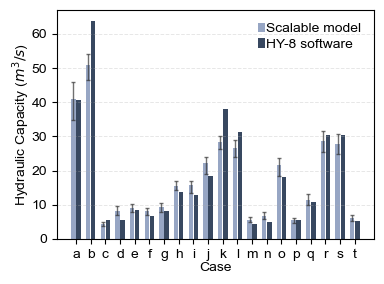

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string


# ---------- prep ----------
# Keep only needed (non-null) rows/cols
filtered_data = specific_rows[
    ['BIN', 'Q', 'Hydraulic Capacity (cfs)', 'possible_Qs', 'average_Q_maxhw', 'possible_Qs_maxhw']
].dropna().copy()

# Min/max from the lists (still in ft³/s at this point)
filtered_data['Q_min'] = filtered_data['possible_Qs'].apply(min)
filtered_data['Q_max'] = filtered_data['possible_Qs'].apply(max)

# If you also need the *_maxhw ranges later, keep these; they’re unused in this plot
filtered_data['Q_min_maxhw'] = filtered_data['possible_Qs_maxhw'].apply(min)
filtered_data['Q_max_maxhw'] = filtered_data['possible_Qs_maxhw'].apply(max)

# Convert ft³/s → m³/s
FT3S_TO_M3S = 0.0283168
filtered_data['Q_m3s'] = filtered_data['Q'] * FT3S_TO_M3S
filtered_data['HC_m3s'] = filtered_data['Hydraulic Capacity (cfs)'] * FT3S_TO_M3S
filtered_data['Q_min_m3s'] = filtered_data['Q_min'] * FT3S_TO_M3S
filtered_data['Q_max_m3s'] = filtered_data['Q_max'] * FT3S_TO_M3S

# Uncertainty (±) around Q, in m³/s
yerr_lower = filtered_data['Q_m3s'] - filtered_data['Q_min_m3s']
yerr_upper = filtered_data['Q_max_m3s'] - filtered_data['Q_m3s']

# ---------- plot ----------
ratio = 1
fig, ax = plt.subplots(figsize=(4*ratio, 3*ratio))


# x: indices 1..N
x = np.arange(1, len(filtered_data) + 1)

# Bars (m³/s)
ax.bar(x, filtered_data['Q_m3s'], width=0.3, color='#97a6c4', label='Scalable model')
ax.bar(x + 0.35, filtered_data['HC_m3s'], width=0.3, color='#384860', label='HY-8 software')

# Uncertainty band on Q (m³/s)
ax.errorbar(
    x, filtered_data['Q_m3s'],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', ecolor='#333333', elinewidth=1, capsize=1.5, alpha=0.7
)

# --- Axes and ticks ---
letters = list(string.ascii_lowercase)[:len(x)]  # a, b, c, ... up to N
ax.set_xticks(x + 0.1725)                        # midpoint between bars
ax.set_xticklabels(letters, fontsize=10)         # label with letters
ax.set_xlabel('Case', fontsize=10, labelpad=1)
ax.set_ylabel('Hydraulic Capacity ($m^3/s$)', fontsize=10, labelpad=0)


# Legend
leg = ax.legend(
    fontsize=10, loc='upper right', handlelength=0.5,
    columnspacing=2.5, handletextpad=0.1, frameon=False, ncol=1, labelspacing=0.2
)
leg.get_title().set_fontweight('bold')

# Grid, layout, save
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.3)
plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\Q_vs_Hydraulic_Capacity_m3s.png',
            dpi=300, bbox_inches='tight')
plt.show()


In [85]:
from sklearn.metrics import r2_score

# --- Error metrics ---
errors = filtered_data['Q_m3s'] - filtered_data['HC_m3s']

mae = errors.abs().mean()
std = errors.std(ddof=1)   # sample standard deviation
r2 = r2_score(filtered_data['Q_m3s'], filtered_data['HC_m3s'])

print(f"Mean Absolute Error (MAE): {mae:.3f} m³/s")
print(f"Standard Deviation of Error: {std:.3f} m³/s")
print(f"R²: {r2:.3f}")


Mean Absolute Error (MAE): 2.769 m³/s
Standard Deviation of Error: 4.243 m³/s
R²: 0.891


In [79]:
import string

# x: indices 1..N
x = np.arange(1, len(filtered_data) + 1)

# Bars (m³/s)
ax.bar(x, filtered_data['Q_m3s'], width=0.3, color='#97a6c4', label='Scalable model')
ax.bar(x + 0.35, filtered_data['HC_m3s'], width=0.3, color='#384860', label='HY-8 software')

# Uncertainty band on Q (m³/s)
ax.errorbar(
    x, filtered_data['Q_m3s'],
    yerr=[yerr_lower, yerr_upper],
    fmt='none', ecolor='#333333', elinewidth=1, capsize=1.5, alpha=0.7
)

# --- Axes and ticks ---
letters = list(string.ascii_lowercase)[:len(x)]  # a, b, c, ... up to N
ax.set_xticks(x + 0.1725)                        # midpoint between bars
ax.set_xticklabels(letters, fontsize=10)         # label with letters
ax.set_xlabel('Index', fontsize=10, labelpad=0)
ax.set_ylabel('Hydraulic Capacity ($m^3/s$)', fontsize=10, labelpad=0)


Text(31.6, 0.5, 'Hydraulic Capacity ($m^3/s$)')

In [64]:
# Create sequential index for x-axis instead of BIN
x = np.arange(1, len(filtered_data) + 1)  # 1 to N

# Bar plot for Hydraulic Capacity (ft³/s)
ax1.bar(x + 0.3, filtered_data['Hydraulic Capacity (cfs)'], width=0.3, 
        label=f'HY-8 software', color='#384860')

# Bar plot for Q (ft³/s)
ax1.bar(x, filtered_data['Q'], width=0.3, color='#97a6c4', label=f'Scalable model')

# Add uncertainty band around Q
ax1.errorbar(
    x, filtered_data['Q'], 
    yerr=[filtered_data['Q'] - filtered_data['Q_min'], 
          filtered_data['Q_max'] - filtered_data['Q']], 
    fmt='none', ecolor='#333333', elinewidth=1, capsize=1.5, alpha=0.7
)

# Set xticks to 1..N
ax1.set_xticks(x)
ax1.set_xticklabels(x, fontsize=9, rotation=0)  # show 1, 2, 3… instead of BIN

# Axis labels
ax1.set_xlabel('Index', fontsize=9, labelpad=0)
ax1.set_ylabel('Hydraulic Capacity\n($ft^3/s$)', fontsize=9, labelpad=0)

# Twin y-axis (m³/s)
ax2 = ax1.twinx()
ax2.set_ylabel('Hydraulic Capacity\n($m^3/s$)', fontsize=9, labelpad=0)

# Sync y-axis scale with conversion factor
factor = 0.0283168
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin * factor, ymax * factor)


(0.0, 66.992097816)

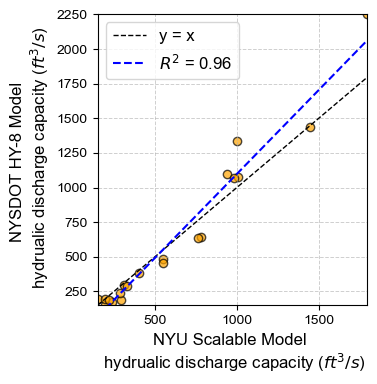

In [532]:
x = filtered_data['Q'].values.reshape(-1, 1)  # NYU model = predictor
y = filtered_data['Hydraulic Capacity (cfs)'].values  # HY-8 model = actual
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)
r2 = r2_score(y, y_pred)  # Correct: compares predicted vs actual

# Plot
plt.figure(figsize=(4, 4))
plt.scatter(x, y, color='orange', edgecolor='black', alpha=0.7)

# Plot 45-degree line (y = x)
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x', linewidth=1)

# Sort for a continuous dashed line
sorted_idx = x.flatten().argsort()
x_sorted = x.flatten()[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]

# Plot regression line correctly
plt.plot(x_sorted, y_pred_sorted, color='blue', linestyle='--', label=f'$R^2$ = {r2:.2f}')
# Labels and formatting
plt.xlabel('NYU Scalable Model \n hydrualic discharge capacity ($ft^3/s$)', fontsize=12)
plt.ylabel('NYSDOT HY-8 Model \n hydrualic discharge capacity ($ft^3/s$)', fontsize=12)
#plt.title('Scatter Plot of hydrualic discharge capacities', fontsize=13)
plt.legend()
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.grid(True,linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()

# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\Scatter_Q_vs_HY8.png', dpi=300)
plt.show()

In [533]:
# Save to Excel
output_path = r"D:\culvert repo\Results\Hydraulic analysis\culvert_filtered_validation.xlsx"
specific_rows[['BIN', 'Hydraulic Capacity (cfs)', 'rise_expected', 
                     'MAXIMUM SPAN LENGTH (FT)', 'DESIGN TYPE', 'BARREL LENGTH','DEPTH OF COVER','HW/D',
                     'GTMS - MATERIAL', 'max_HW_D','HW/D','average_Q_maxhw',
                      'Q','Hydraulic Capacity (cfs)']].to_excel(output_path, index=False)

# Visualization

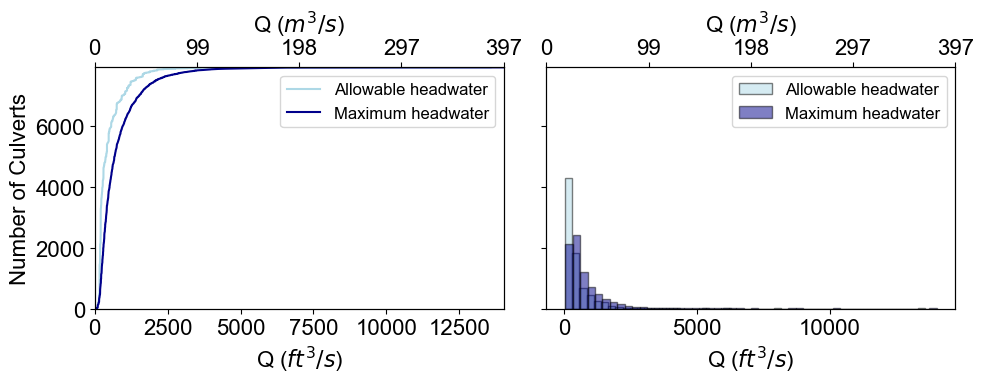

In [595]:
# Extract the discharge data
culvert_data = culvert['Q']
culvert_max_data = culvert['Q_max']

# Compute the CDFs
sorted_Q = np.sort(culvert_data)
sorted_Qmax = np.sort(culvert_max_data)
cdf_Q = np.arange(1, len(sorted_Q) + 1)
cdf_Qmax = np.arange(1, len(sorted_Qmax) + 1)

# Convert to m³/s
sorted_Q_m3s = sorted_Q * 0.0283168
sorted_Qmax_m3s = sorted_Qmax * 0.0283168

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

tick_fontsize = 16

# --- CDF Plot ---
ax1 = axes[0]
ax1.plot(sorted_Q, cdf_Q, linestyle='-', color='lightblue', label='Allowable headwater')
ax1.plot(sorted_Qmax, cdf_Qmax, linestyle='-', color='darkblue', label='Maximum headwater')
ax1.set_xlabel("Q ($ft^3/s$)", fontsize=16)
ax1.set_ylabel("Number of Culverts", fontsize=16)
ax1.set_xlim(0, max(max(sorted_Q), max(sorted_Qmax)))
ax1.tick_params(axis='both', labelsize=tick_fontsize)
ax1.legend(fontsize=12)

# Secondary x-axis (m³/s)
ax1_secondary = ax1.twiny()
ax1_secondary.set_xlim(0, max(max(sorted_Q_m3s), max(sorted_Qmax_m3s)))
ax1_secondary.set_xlabel("Q ($m^3/s$)", fontsize=16)
ax1_secondary.set_xticks(np.linspace(0, max(sorted_Qmax_m3s), num=5))
ax1_secondary.set_xticklabels([f"{int(x)}" for x in np.linspace(0, max(sorted_Qmax_m3s), num=5)], fontsize=tick_fontsize)

# --- Histogram ---
ax2 = axes[1]
ax2.hist(sorted_Q, bins=50, density=False, alpha=0.5, color='lightblue', edgecolor='black', label='Allowable headwater')
ax2.hist(sorted_Qmax, bins=50, density=False, alpha=0.5, color='darkblue', edgecolor='black', label='Maximum headwater')
ax2.set_xlabel("Q ($ft^3/s$)", fontsize=16)
ax2.tick_params(axis='both', labelsize=tick_fontsize)
ax2.legend(fontsize=12)

# Secondary x-axis (m³/s)
ax2_secondary = ax2.twiny()
ax2_secondary.set_xlim(0, max(max(sorted_Q_m3s), max(sorted_Qmax_m3s)))
ax2_secondary.set_xlabel("Q ($m^3/s$)", fontsize=16)
ax2_secondary.set_xticks(np.linspace(0, max(sorted_Qmax_m3s), num=5))
ax2_secondary.set_xticklabels([f"{int(x)}" for x in np.linspace(0, max(sorted_Qmax_m3s), num=5)], fontsize=tick_fontsize)

# Match y-axis limits
ax1.set_ylim(0, max(cdf_Q))
ax2.set_ylim(0, max(cdf_Q))

plt.tight_layout()
plt.savefig(r'D:\culvert repo\Results\Figures\cdf_histogram_Q.png', dpi=300)
plt.show()

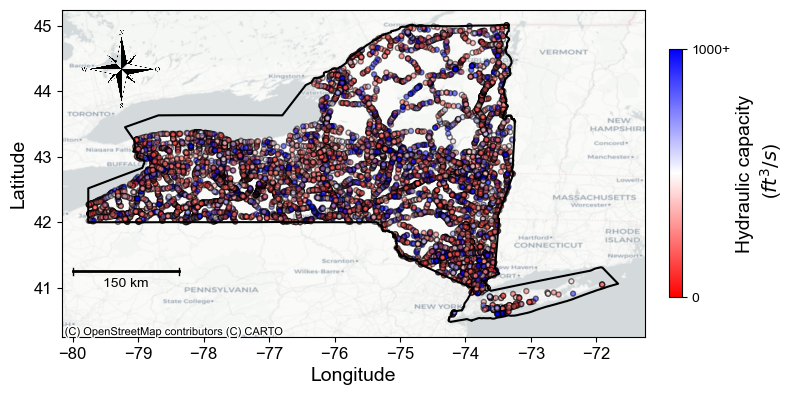

In [596]:
# Load the shapefile into a GeoDataFrame
shapefile_path = r"D:\culvert repo\data\initial layers\culvert_5070.shp"
geom_gdf = gpd.read_file(shapefile_path)

# Merge hydraulic capacity data
geom_gdf = geom_gdf.merge(culvert[['BIN', 'Q']], on='BIN', how='left')

# Define colormap and normalization
cmap = plt.get_cmap('bwr_r')
norm = mcolors.Normalize(vmin=0, vmax=1000)

geom_gdf['color'] = geom_gdf['Q'].apply(
    lambda q: cmap(norm(q)) if q < 1000 else 'blue'
)

# Reproject to EPSG:4326 for plotting
crs_deg = 'EPSG:4326'
crs_m = 'EPSG:5070'
geom_gdf = geom_gdf.to_crs(crs_deg)

# Get bounds
minx, miny, maxx, maxy = geom_gdf.total_bounds

# Estimate meters-per-degree using reprojected bounding box
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs=crs_deg).to_crs(crs_m)
scale_width_m = bbox_gdf.geometry[0].bounds[2] - bbox_gdf.geometry[0].bounds[0]
scale_width_deg = maxx - minx
meters_per_degree = scale_width_m / scale_width_deg

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
geom_gdf.plot(ax=ax, color=geom_gdf['color'], edgecolor='k', alpha=0.5, markersize=13)

#boundary
base_dir = r'D:\culvert repo\data\initial layers'
state_shapefile = gpd.read_file(fr"{base_dir}\state_5070.shp").to_crs(crs_deg)
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none')


# Add basemap
ctx.add_basemap(ax, crs=geom_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Colorbar for values <= 1000
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label(f'Hydraulic capacity\n ($ft^3/s$)', fontsize=14)
cbar.set_ticks([0, 1000])
cbar.set_ticklabels(['0', '1000+'])

# Axis labels and title
#ax.set_title("Culverts' hydraulic capacity", fontsize=18)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# -------------------- Scale Bar --------------------
bar_length_km = 150
deg_per_km = 1 / (meters_per_degree / 1000)
bar_length_deg = bar_length_km * deg_per_km

bar_x_start = -80  # adjust if necessary
bar_x_end = bar_x_start + bar_length_deg
bar_y = 41.25

# Draw scale bar line and ticks
ax.plot([bar_x_start, bar_x_end], [bar_y, bar_y], color='black', lw=2)
ax.plot([bar_x_start, bar_x_start], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.plot([bar_x_end, bar_x_end], [bar_y - 0.05, bar_y + 0.05], color='black', lw=1)
ax.text((bar_x_start + bar_x_end) / 2, bar_y - 0.1, f'{bar_length_km} km', ha='center', va='top',
        fontsize=10, bbox=dict(facecolor='white', alpha=.1, edgecolor='none', boxstyle='round,pad=0.2'))

# -------------------- North Arrow --------------------
img_path = r'D:\culvert repo\Results\north_arrow\N_arrow.png'
north_img = mpimg.imread(img_path)
imagebox = OffsetImage(north_img, zoom=0.09)
ab = AnnotationBbox(imagebox, (0.1, 0.82), xycoords='axes fraction', frameon=False)
ax.add_artist(ab)


# Save and show
plt.savefig(r'D:\culvert repo\Results\Figures\hydraulic_discharge_limit2000.png', dpi=300)
plt.show()

In [ ]:
# Load the shapefile into a GeoDataFrame
geom_gdf = gpd.read_file(shapefile_path)

# Reproject the GeoDataFrame to EPSG:4326
geom_gdf = geom_gdf.to_crs(epsg=4326)

# Merge the new data with the existing GeoDataFrame
geom_gdf = geom_gdf.merge(culvert[['BIN', 'Q', 'possible_Qs','average_Q_maxhw','possible_Qs_maxhw']], on='BIN', how='left')

# Remove rows with NaN values in the 'Q' column
geom_gdf = geom_gdf.dropna(subset=['Q'])
# Initialize a Folium map
m = folium.Map(location=[geom_gdf.geometry.centroid.y.mean(), geom_gdf.geometry.centroid.x.mean()], zoom_start=10)
# Create a color scale function using matplotlib
def color_function(q):
    norm = plt.Normalize(vmin=0, vmax=2000)  # Normalize for Q range between 0 and 2000
    cmap = plt.get_cmap('RdYlBu')  # Red-Yellow-Blue color map
    rgba = cmap(norm(q))  # Map the value of Q to color
    return 'rgba({}, {}, {}, {})'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255), rgba[3])
# Add culvert data to the map without marker clustering
for _, row in geom_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color_function(row['Q']),
        fill=True,
        fill_color=color_function(row['Q']),
        fill_opacity=0.7,
        
        popup=folium.Popup(f"BIN: {row['BIN']}<br> Maximum hydraulic capacity before overtopping (ft<sup>3</sup>/s): {int(row['Q'])} <br> \
                            Uncertainty range of maximum hydraulic capacity before overtopping (ft<sup>3</sup>/s): [{int(min(row['possible_Qs']))}, {int(max(row['possible_Qs']))}] <br> \
                            Maximum hydraulic capacity before structural damage (ft<sup>3</sup>/s): {int(row['average_Q_maxhw'])}<br> \
                            Uncertainty range of maximum hydraulic capacity before structural damage (ft<sup>3</sup>/s): [{int(min(row['possible_Qs_maxhw']))}, {int(max(row['possible_Qs_maxhw']))}] ", max_width=300)
        
    ).add_to(m)
# Add a basemap layer (you can choose different layers based on your preference)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI Topo",
    name="ESRI Topographic",
    control=True
).add_to(m)

# USGS Hydrography (Shows Streams and Water Bodies)
folium.TileLayer(
    tiles="https://basemap.nationalmap.gov/arcgis/rest/services/USGSHydroCached/MapServer/tile/{z}/{y}/{x}",
    attr="USGS Hydrography",
    name="USGS Hydrography"
).add_to(m)

folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI',
    name='ESRI Satellite',
    max_zoom=100,
    control=True
).add_to(m)

folium.LayerControl().add_to(m)

# Add plugins
folium.plugins.Geocoder().add_to(m)
folium.plugins.LocateControl().add_to(m)
folium.plugins.MousePosition().add_to(m)
folium.plugins.MeasureControl().add_to(m)

# Attribution footer
attribution_html = Element("""
<div style="
    position: fixed;
    bottom: 0px;
    left: 50%;
    transform: translateX(-50%);
    width: 70%;
    background-color: white;
    text-align: center;
    font-size: 14px;
    font-family: Arial, sans-serif;
    z-index: 9999;
    padding: 8px 0;
    border-bottom: 1px solid #ccc;
    box-shadow: 0 2px 6px rgba(0,0,0,0.1);
">
    Developed by <a href="https://www.omidemam.com/" target="_blank">Omid Emamjomehzadeh</a>,
    supervised by <a href="https://engineering.nyu.edu/faculty/omar-wani" target="_blank">Dr. Omar Wani</a> at 
    <a href="https://www.omarwani.com/" target="_blank">Hydrologic Systems Group @NYU</a>
</div>
""")

m.get_root().html.add_child(attribution_html)

# Save the map to an HTML file
m.save(r'D:\culvert repo\Results\Figures\hydraulic_discharge_map.html')
# Display the map (in Jupyter Notebook, for example)
m

#### Save the final results

In [598]:
# Save to Excel
output_path=r'D:\culvert repo\Results\Hydraulic analysis\hydraulic_analysis.xlsx'
culvert.to_excel(output_path, index=False)

In [ ]:
#Getting the current date and time
current_datetime = datetime.now()
# Printing the date and time
print("Date and Time of the Notebook Analysis:", current_datetime)

Date and Time of the Notebook Analysis: 2025-07-21 15:00:40.572476


In [600]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,sklearn,scipy,folium,contextily,seaborn,geopandas,matplotlib,shapely

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
sklearn   : 1.5.1
scipy     : 1.13.1
folium    : 0.17.0
contextily: 1.6.1
seaborn   : 0.13.2
geopandas : 1.0.1
matplotlib: 3.8.4
shapely   : 2.0.7

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

